# Example 1: A first OCTA analysis

This Example will perform a first simple analysis of two OCTA images.
We will first copy some example images into our working directory (Step 1). Notes on how to prepare the images can be found in examples/example_patients/HowToAnnotate.md.
 We will then show how the input images can be converted to Nifti Images (Step 2).
Then, we will perform a simple analysis of Vessel Area Density (VAD) of the single images (Step 3).


In [4]:
### Step 1: Copy example patients
import os.path as path
import os
import OpenOCTAAnalyzer as octa
import skimage
import pickle 
import numpy as np
import cv2

import os
import shutil
import re

# Check if input folder exists
source_folder = "../example_patients"
destination_folder = "../example_analyzePatients/input"

if os.path.exists(destination_folder):
    user_input = input(f"The folder '{destination_folder}' already exists. Do you want to proceed and delete it? (y/n): ").lower()
    if user_input != 'y':
        print("Aborting execution.")
        exit()
    else:
        # Delete the existing folder
        shutil.rmtree(destination_folder)
        print(f"Deleted the existing '{destination_folder}' folder.")

# Define a function to recursively copy the directories
def copy_files_recursive(source, destination):
    for root, dirs, files in os.walk(source):
        relative_path = os.path.relpath(root, source)
        destination_path = os.path.join(destination, relative_path)

        # Create the directory if it doesn't exist
        os.makedirs(destination_path, exist_ok=True)

        # Copy files to the destination
        for file in files:
            source_file_path = os.path.join(root, file)
            destination_file_path = os.path.join(destination_path, file)
            shutil.copy2(source_file_path, destination_file_path)

# Copy the directories
os.makedirs(destination_folder, exist_ok=True)
copy_files_recursive(source_folder, destination_folder)
print(f"Files and subfolders copied from '{source_folder}' to '{destination_folder}'.")

Deleted the existing '../example_analyzePatients/input' folder.
Files and subfolders copied from '../example_patients' to '../example_analyzePatients/input'.


We have now successfully copied the patient data.
Let's convert and crop these images!

In [5]:
### Step 2: Convert the images
___use_cv2 = False              # This option may be used if cv2 is preferred over skimage

# Function to extract scan parameters
def extract_scan_parameters(file_path):
    with open(file_path, 'r') as file:
        content = file.read()

    size_x_match = re.search(r'Size X: (\d+)', content)
    num_b_scans_match = re.search(r'Number of B-Scans: (\d+)', content)
    scaling_x_match = re.search(r'Scaling X: ([\d.]+) µm/pixel', content)

    size_x = int(size_x_match.group(1)) if size_x_match else None
    num_b_scans = int(num_b_scans_match.group(1)) if num_b_scans_match else None
    scaling_x = float(scaling_x_match.group(1)) if scaling_x_match else None

    return size_x, num_b_scans, scaling_x

for dirpath, dirs, files in os.walk(destination_folder):
    #for dir in dirs:
    filelist= [file for file in os.listdir(dirpath) if file.endswith('.png') or file.endswith('.jpg')]
    for file in filelist:
        if "Localizer" in file:
            print(f"Found dir '{dirpath}'... will parse")
            if not ___use_cv2:
                image = skimage.io.imread(os.path.join(dirpath, file))
            else:  
                image = cv2.imread(os.path.join(dirpath, file))
            if np.shape(image)[2] == 4:
                image = skimage.color.rgba2rgb(image)
                
            pos = octa.localizeEdgesAndFovea(image, edgeColor=[255,0,0] if ___use_cv2 else [0,0,255], foveaColor=[0,255,0])

            ## load exam parameters
            size_x, size_y, scaling_x = extract_scan_parameters(path.join(dirpath, 'exam_parameters.txt'))

            with open(path.join(dirpath, 'pos.pkl'), 'wb') as f:
                
                width, height = pos['edges'][1][0] - pos['edges'][0][0], pos['edges'][1][1] - pos['edges'][0][1] 
                pos['foveaPos'] = (pos['foveaPos'][0] * size_x // width, pos['foveaPos'][1] * size_y // height)
                pos['resize'] = (size_x, size_y)
                pos['scaling_x'] = scaling_x
                pickle.dump(pos, f)
            
            for file2 in filelist:
                #print("")
                octa.image2Nifti(path.join(dirpath, file2), cropArray=pos) #,path.join(this_dir, os.path.splitext(file2)[0] + ".nii"),pos)

Found dir '../example_analyzePatients/input/patient1'... will parse
Found dir '../example_analyzePatients/input/patient2'... will parse


OK, cool, the files are parsed. But how can we analyze them?

In [24]:
### Step 3: Analyze the patients

# First, we will create a function that will analyze a whole directory
def analyzeDirectory(dir):
    print(f"Analyze Dir {dir}...")
    filelist = [path.join(dir, x) for x in np.sort([file for file in os.listdir(dir) if file.endswith('.nii') and "Localizer" not in file])]

    # load and segment big vessels from SCP
    svp_file = [s for idx, s in enumerate(filelist) if 'SVP' in s][0]
    svp = octa.loadNifti(svp_file)
    vessels = octa.OpenOCTAAnalyzerFilters.isolateBigVessels(svp)

    all_seg = np.ones(np.shape(svp)) == 1

    # load the fovea position
    with open(path.join(dir, "pos.pkl"), 'rb') as f:
        pos = pickle.load(f)

    um_per_pixel = pos["scaling_x"]
    um_per_pixel /= np.shape(all_seg)[1] / pos["resize"][0]

    fovea_pos = (pos["foveaPos"][0], pos["foveaPos"][1])

    # To analyze: We will first do an analysis of two etdrs segments: the central 1mm and the ring from 3 to 1 mm
    etdrs_1mm = octa.createRingSegmentationDiameter(all_seg, fovea_pos, 1000 / 2 / um_per_pixel)
    etdrs_3mm = octa.createRingSegmentationDiameter(all_seg, fovea_pos, 3000 / 2 / um_per_pixel, 1000 / 2 / um_per_pixel)
    
    # if we want to isolate single etdrs segments, we can achieve this as follows:
    wedge_bottom = octa.createWedge(etdrs_3mm, fovea_pos, (1,0))
    wedge_top = octa.createWedge(etdrs_3mm, fovea_pos, (-1,0))
    wedge_right = octa.createWedge(etdrs_3mm, fovea_pos, (0,1))
    wedge_left = octa.createWedge(etdrs_3mm, fovea_pos, (0,-1))

    # now we can combine the wedges with the ring segment
    etdrs_3mm_top = np.copy(etdrs_3mm)
    etdrs_3mm_top[wedge_top == False] = False

    # now, lets do some analysis on some examplery areas
    segmentations = {"Whole Image": all_seg,        
                     "ETDRS Ring 1mm": etdrs_1mm,   
                     "ETDRS Ring 3-1mm": etdrs_3mm, 
                     "ETDRS 3mm Top Wedge": etdrs_3mm_top}
                     
    segmentations2 = segmentations.copy()

    for s in segmentations2:
        print(s, segmentations[s].shape, vessels.shape)
        segmentations[f"{s} (without big vessels)"] = np.copy(segmentations[s])
        segmentations[f"{s} (without big vessels)"][vessels == True] = False

    res = (octa.analyzeSegmentations(filelist, segmentations, output_excel_file=path.join(dir, "analysis.xlsx"), filters={"raw": octa.OpenOCTAAnalyzerFilters.standardRaw, "otsuVAD": octa.OpenOCTAAnalyzerFilters.standardOtsu, "frangiVAD": octa.OpenOCTAAnalyzerFilters.standardFrangi, "frangiVLD": octa.OpenOCTAAnalyzerFilters.standardFrangiVLD}, output_pdf_file=path.join(dir, "analysis.pdf")))
    print("Finished")

import os

for dirpath, dirs, files in os.walk(destination_folder):
    filelist= [file for file in os.listdir(dirpath) if file.endswith('.pkl')]
    for file in filelist:
        if "pos.pkl" in file:
            print(f"Analyzing {dirpath}...")
            analyzeDirectory(dirpath)

            if False:
                filelist= [file for file in os.listdir(this_dir) if file.endswith('.nii')]

                if len(filelist) > 0:
                    print(f"Found dir '{this_dir}'... will parse")
                    for file in filelist:
                        
                        #if not os.path.exists(path.join(this_dir, "analysis_old.xlsx")):
                        #    shutil.copy(path.join(this_dir, "analysis.xlsx"), path.join(this_dir, "analysis_old.xlsx"))
                        #OCTAnalyzer.double_segmentation(path.join(this_dir, file), path.join(this_dir, "Segmentation2.nii"), 1, 3)
                        analyzeDirectory(this_dir)

Analyzing ../example_analyzePatients/input/patient1...
Analyze Dir ../example_analyzePatients/input/patient1...
Whole Image (512, 512) (512, 512)
ETDRS Ring 1mm (512, 512) (512, 512)
ETDRS Ring 3-1mm (512, 512) (512, 512)
ETDRS 3mm Top Wedge (512, 512) (512, 512)
Finished
Analyzing ../example_analyzePatients/input/patient2...
Analyze Dir ../example_analyzePatients/input/patient2...
Whole Image (512, 512) (512, 512)
ETDRS Ring 1mm (512, 512) (512, 512)
ETDRS Ring 3-1mm (512, 512) (512, 512)
ETDRS 3mm Top Wedge (512, 512) (512, 512)
Finished


Okay, now we have analyzed two OCTA images.
The detailed analysis is in the analysis.xlsx file in the patient directory.
Also, a debug pdf was created that shows all analysis.

As for this example, let's display two results for patient 1:
1. The numeric results of the frangiVAD measurements for all segmentations
2. For the ETDRS Ring 3-1mm without big vessels: all debug images.

,Unnamed: 0,Patient1 OD DCP.nii,Patient1 OD ICP.nii,Patient1 OD SVP.nii
0,Whole Image,0.235683,0.227741,0.287437
1,ETDRS Ring 1mm,0.052632,0.153859,0.122875
2,ETDRS Ring 3-1mm,0.256482,0.238001,0.307113
3,ETDRS 3mm Top Wedge,0.258987,0.235326,0.304254
4,Whole Image (without big vessels),0.227207,0.213614,0.250189
5,ETDRS Ring 1mm (without big vessels),0.047371,0.143285,0.101602
6,ETDRS Ring 3-1mm (without big vessels),0.252037,0.226531,0.272637
7,ETDRS 3mm Top Wedge (without big vessels),0.256612,0.218642,0.268134


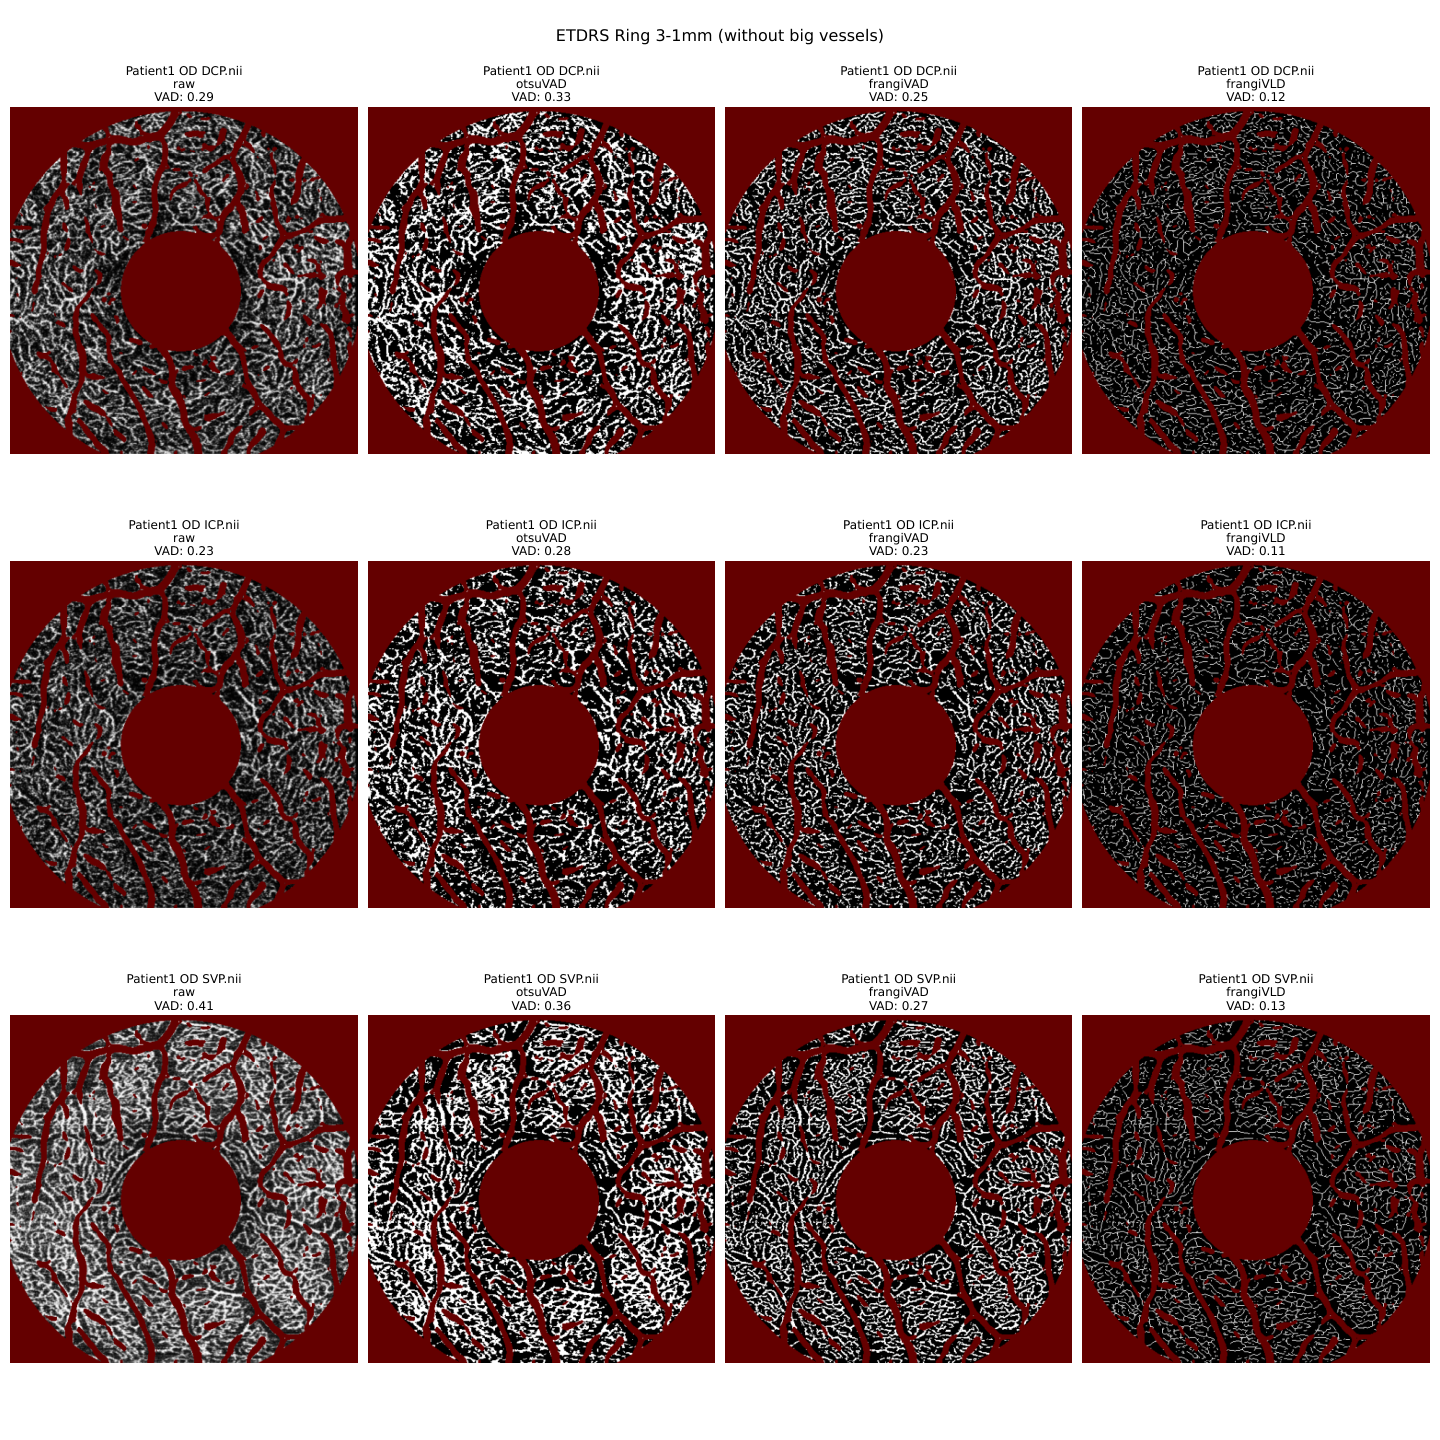

In [25]:
import fitz  # PyMuPDF
from IPython.display import display, Image
import pandas as pd

def display_excel_sheet(excel_path, sheet_name):
    # Read the Excel file
    df = pd.read_excel(excel_path, sheet_name=sheet_name)

    # Display the DataFrame as a table in the Jupyter Notebook
    display(df)

excel_path = 'input/patient1/analysis.xlsx'
sheet_name = 'frangiVAD'  
display_excel_sheet(excel_path, sheet_name)

def display_pdf_page(pdf_path, page_number):
    # Open the PDF file
    pdf_document = fitz.open(pdf_path)

    # Get the specified page (adjust the index as needed)
    page = pdf_document[page_number - 1]

    # Convert the PDF page to a PNG image
    pixmap = page.get_pixmap()

    img = pixmap.tobytes()
    #image_data = pixmap.get_png_data()
    image = Image(data=img) #image_data)

    # Display the image in the Jupyter Notebook
    display(image)

    # Close the PDF document
    pdf_document.close()

pdf_path = 'input/patient1/analysis.pdf' 
display_pdf_page(pdf_path, page_number=7)
